# Сборный проект №2

***Предисловие***

В данном проекте нам необходимо изучить поведение пользователей приложения, какие страницы они посещают чаще всего, на каком этапе снижается их кол-во, сколько пользователей от общего числа по итогу доходит до покупки.
У нас имеются данные за период с конца июля (25.07) по начало августа (07.08) за 2019 год. Необходимо проверить по всем ли датам есть данные о поведении пользователей. И имеется три группы - две контрольных и одна эксперементальная.
По итогу нам нужно понять, как повлияет на поведение пользователей смена шрифта.

Перед началом анализа импортируем все необходимые библиотеки

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import math as mth

## Подготовка данных

In [21]:
data = pd.read_csv('logs_exp.csv', sep='\t')

In [22]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [24]:
#изменяем названия столбцов
data.columns = ['e_name', 'device_id', 'event_date', 'group']

In [25]:
#проверяем на явные дубликаты
duplicated = data.duplicated()
print('\nДубликатов в выгрузке: {}'.format(data.duplicated().sum()))


Дубликатов в выгрузке: 413


In [26]:
#посчитаем, какой процент дубликаты составляют от общего кол-ва данных
print('Доля дубликатов в данных:', round(duplicated.sum()/len(data) *100, 2))

Доля дубликатов в данных: 0.17


In [27]:
data = data.drop_duplicates().reset_index(drop = True)
print('Дубликаты удалены, дубликатов осталось: {}'.format(data.duplicated().sum()))

Дубликаты удалены, дубликатов осталось: 0


In [28]:
repeated = (data[['device_id', 'group']].groupby('group', as_index=False).agg({'device_id':'nunique'}).query('group>1'))
repeated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   group      3 non-null      int64
 1   device_id  3 non-null      int64
dtypes: int64(2)
memory usage: 72.0 bytes


In [29]:
data_1 = data.query('device_id not in @repeated')
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   e_name      243713 non-null  object
 1   device_id   243713 non-null  int64 
 2   event_date  243713 non-null  int64 
 3   group       243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [30]:
#добавляем столбцы даты и времени и отдельно даты

data['dt'] = pd.to_datetime(data['event_date'], unit='s')

data['date'] = data['dt'].dt.floor('1D')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   e_name      243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_date  243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   dt          243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


В данных были дубликаты, но их процент был незначительным и мы от них избавились.
Пропусков в данных не было обнаружено.

## Проверка данных

In [31]:
#узнаем период для анализа
print('Начало периода:', data['date'].min())
print('Конец периода', data['date'].max())

Начало периода: 2019-07-25 00:00:00
Конец периода 2019-08-07 00:00:00


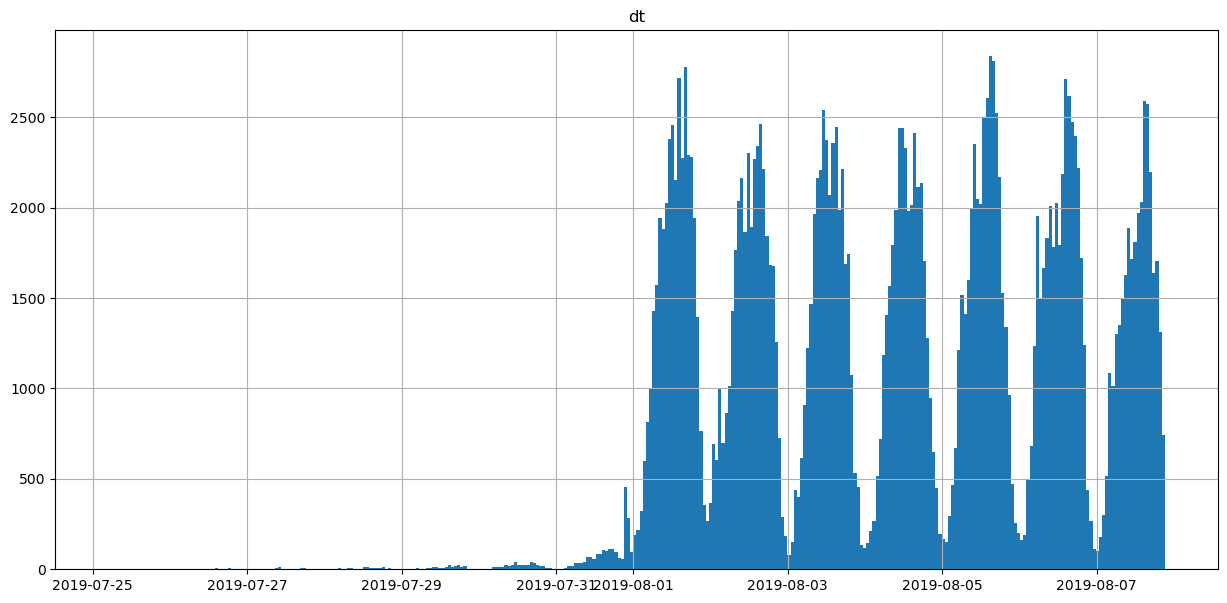

In [32]:
data.hist('dt', figsize=(15,7), bins=14*24)
plt.show()

Исходя из гистограммы, нельзя сказать, что у нас полные данные за весь период. Можно заметить, как в самом начале периоды, то есть 25.07.19г. по 01.08.19г. данные практически отсутсвуют.

In [33]:
data_fltrd = data[data['dt'] >= '2019-08-01 00:00:00']
data_fltrd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   e_name      240887 non-null  object        
 1   device_id   240887 non-null  int64         
 2   event_date  240887 non-null  int64         
 3   group       240887 non-null  int64         
 4   dt          240887 non-null  datetime64[ns]
 5   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


In [34]:
print('Отбросив старые данные, было потеряно', len(data)-len(data_fltrd), 'или', round((len(data)-len(data_fltrd))/len(data) *100,2),'процента от данных')

Отбросив старые данные, было потеряно 2826 или 1.16 процента от данных


In [35]:
print(len(data['device_id'].unique()))
print(len(data_fltrd['device_id'].unique()))

7551
7534


In [36]:
print('Отбросив старые данные, было потеряно', len(data)-len(data_fltrd), 'или', round((len(data)-len(data_fltrd))/len(data) *100,2),'процента от данных')

Отбросив старые данные, было потеряно 2826 или 1.16 процента от данных


In [37]:
print('Отбросив старые данные, было потеряно',len(data['device_id'].unique())-len(data_fltrd['device_id'].unique()),' уникальных пользователей')

Отбросив старые данные, было потеряно 17  уникальных пользователей


In [38]:
print('По итогу мы имеем:')

print('Всего событий: {}'.format(len(data_fltrd)))
print('Всего пользователей: {}'.format(len(data_fltrd['device_id'].unique())))
print('В среднем событий на одного пользователя до фильтрации: {}'.format(data.groupby('device_id')['e_name'].count().mode()[0]))
print('В среднем событий на одного пользователя после фильтрации: {}'.format(data_fltrd.groupby('device_id')['e_name'].count().mode()[0]))
for group in data_fltrd['group'].unique():
    print('Кол-во событий в группе {}: {}'.format(group , len(data_fltrd[data_fltrd['group']==group])))

По итогу мы имеем:
Всего событий: 240887
Всего пользователей: 7534
В среднем событий на одного пользователя до фильтрации: 5
В среднем событий на одного пользователя после фильтрации: 6
Кол-во событий в группе 246: 79302
Кол-во событий в группе 247: 77022
Кол-во событий в группе 248: 84563


In [39]:
#Также посчитаем уникальных пользователей в каждой группе
data_fltrd.groupby('group').agg({'device_id': 'nunique'})

,device_id
group,
246,2484
247,2513
248,2537


## Воронка пользователей

In [40]:
#Посмотрим, какие события встречаются в данных, проанализируем их частоту
events = data_fltrd.pivot_table(index='e_name', values={'device_id', 'date'}, aggfunc={'device_id':'nunique', 'date':'count'}).sort_values(by='device_id', ascending=False)
events.columns = ['events','users']
events

,events,users
e_name,,
MainScreenAppear,117328,7419
OffersScreenAppear,46333,4593
CartScreenAppear,42303,3734
PaymentScreenSuccessful,33918,3539
Tutorial,1005,840


Самым частым является посещение главной страницы, как в целом, так и если посмотреть на уникальное данное событие

In [41]:
users_per_event = (
    data_fltrd
    .pivot_table(index='e_name', values='device_id', aggfunc=lambda x: x.nunique())
    .sort_values('device_id', ascending=False)
)
events['change_in_users'] = round(users_per_event / len(data['device_id'].unique()) *100, 2)
events

,events,users,change_in_users
e_name,,,
MainScreenAppear,117328,7419,98.25
OffersScreenAppear,46333,4593,60.83
CartScreenAppear,42303,3734,49.45
PaymentScreenSuccessful,33918,3539,46.87
Tutorial,1005,840,11.12


Выше мы посчитали долю пользователей, которые совершали каждое событие.

Предположим, что события идут как раз в порядке сортировки в таблице выше, то есть сначала покупатель смотрит главный экран, потом предложения, потом корзину и далее оплата. К этапу с обучением каждый пользователь может приходить в необходимый ему момент, к тому же крайне мало покупателей прибегают к нему, так что мы уберем данные по нему из дальнейшего анализа.  

In [42]:
tutorial = data_fltrd.query('e_name == "Tutorial"')
tutorial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 2826 to 243129
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   e_name      1005 non-null   object        
 1   device_id   1005 non-null   int64         
 2   event_date  1005 non-null   int64         
 3   group       1005 non-null   int64         
 4   dt          1005 non-null   datetime64[ns]
 5   date        1005 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 55.0+ KB


In [43]:
print('Данные по просмотру обучения составляют всего', round(len(tutorial)/len(data_fltrd) *100,2), ',что меньше даже 1%')

Данные по просмотру обучения составляют всего 0.42 ,что меньше даже 1%


In [44]:
#уберем данные по просмотру обучения
data_fltrd = data_fltrd.query('e_name!="Tutorial"')
data_fltrd

,e_name,device_id,event_date,group,dt,date
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2831,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [45]:
events.reset_index()

,e_name,events,users,change_in_users
0,MainScreenAppear,117328,7419,98.25
1,OffersScreenAppear,46333,4593,60.83
2,CartScreenAppear,42303,3734,49.45
3,PaymentScreenSuccessful,33918,3539,46.87
4,Tutorial,1005,840,11.12


In [46]:
events['change'] = events['users'].pct_change() + 1
events['change'] = round(events['change']*100,2)                    
events = events.fillna(100)

In [47]:
events

,events,users,change_in_users,change
e_name,,,,
MainScreenAppear,117328,7419,98.25,100.00
OffersScreenAppear,46333,4593,60.83,61.91
CartScreenAppear,42303,3734,49.45,81.30
PaymentScreenSuccessful,33918,3539,46.87,94.78
Tutorial,1005,840,11.12,23.74


Мы посчитали долю пользователей, которая переходит на следующий этап.

На основании этих данных, можно сделать вывод, что больше всего пользователей теряется на первом этапе - переходе с главной страницы на страницу с предложениями.

In [48]:
MainScreen = events.query('e_name == "MainScreenAppear"')
PaymentScreen = events.query('e_name == "PaymentScreenSuccessful"')

In [49]:
print('Доля пользователей, которая доходит с главного экрана до оплаты:', round(events.loc['PaymentScreenSuccessful', 'users']/events.loc['MainScreenAppear', 'users'] * 100, 2))

Доля пользователей, которая доходит с главного экрана до оплаты: 47.7


## Изучение результатов эксперимента

In [65]:
#Кол-во уникальных пользователей в каждой группе после всех чисток
event_group = data_fltrd.pivot_table(index='group', values='device_id', aggfunc='nunique')

event_group = event_group.T
event_group.columns = ['246', '247', '248']

event_group

,246,247,248
device_id,2483,2512,2535


In [66]:
event_parts_per_groups = data_fltrd.pivot_table(index='e_name', values='device_id', columns='group', aggfunc='nunique', margins=True)

In [68]:
event_parts_per_groups

group,246,247,248,All
e_name,,,,
CartScreenAppear,1266,1238,1230,3734
MainScreenAppear,2450,2476,2493,7419
OffersScreenAppear,1542,1520,1531,4593
PaymentScreenSuccessful,1200,1158,1181,3539
All,2483,2512,2535,7530


In [72]:
event_parts_per_groups.columns = ['246', '247', '248', 'all']
event_parts_per_groups = event_parts_per_groups.drop(columns=['all'], axis=1)

In [73]:
#рассмотрим отдельно события для каждой группы 
event_parts_per_groups = event_parts_per_groups.sort_values(by='246', ascending=False)
event_parts_per_groups

,246,247,248
e_name,,,
All,2483,2512,2535
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [74]:
event_parts_per_groups['246+247'] = event_parts_per_groups['246'] + event_parts_per_groups['247']

In [75]:
event_parts_per_groups['e_name'] = event_parts_per_groups.index

In [76]:
#создадим функцию для подсчета значимости статистических критериев разницы между выборками 
def hypothesis (success_1, success_2, trials_1, trials_2, alpha):
    
    p1 = success_1/trials_1
    
    p2 = success_2/trials_2
    
    p_comb = (success_1+success_2)/(trials_1+trials_2)
    
    diff = p1 - p2
    
    z_value = diff / mth.sqrt(p_comb * (1 - p_comb) * (1/trials_1 + 1/trials_2))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha: print('Отвергаем нулевую гипотезу: между долями есть значимая разница') 
    
    else: print( 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' )

for i in event_parts_per_groups['e_name']:
    success_1 = event_parts_per_groups[event_parts_per_groups['e_name']==i]['246']
    success_2 = event_parts_per_groups[event_parts_per_groups['e_name']==i]['247']
    success_3 = event_parts_per_groups[event_parts_per_groups['e_name']==i]['248']
    success_4 = event_parts_per_groups[event_parts_per_groups['e_name']==i]['246+247']

trials_1 = event_group.loc['device_id', '246']
trials_2 = event_group.loc['device_id', '247']
trials_3 = event_group.loc['device_id', '248']
trials_4 = trials_1 + trials_2
alpha = 0.05

In [77]:
event_parts_per_groups['total'] = event_parts_per_groups['246+247']+event_parts_per_groups['248']
event_parts_per_groups

,246,247,248,246+247,e_name,total
e_name,,,,,,
All,2483,2512,2535,4995,All,7530
MainScreenAppear,2450,2476,2493,4926,MainScreenAppear,7419
OffersScreenAppear,1542,1520,1531,3062,OffersScreenAppear,4593
CartScreenAppear,1266,1238,1230,2504,CartScreenAppear,3734
PaymentScreenSuccessful,1200,1158,1181,2358,PaymentScreenSuccessful,3539


In [78]:
print(event_group.loc['device_id', '246'])

2483


Самым популярным событием является просмотр главной страницы.


In [79]:
print('Доля пользователей, посетивших главную страницу в 246 группе:', round(event_parts_per_groups.loc['MainScreenAppear', '246']/event_group.loc['device_id', '246'] *100, 2))
print('Доля пользователей, посетивших главную страницу в 247 группе:', round(event_parts_per_groups.loc['MainScreenAppear', '247']/event_group.loc['device_id', '247'] *100, 2))
print('Доля пользователей, посетивших главную страницу в 247 группе:', round(event_parts_per_groups.loc['MainScreenAppear', '248']/event_group.loc['device_id', '248'] *100, 2))

Доля пользователей, посетивших главную страницу в 246 группе: 98.67
Доля пользователей, посетивших главную страницу в 247 группе: 98.57
Доля пользователей, посетивших главную страницу в 247 группе: 98.34


Для всех групп доля, посетивших главную страницу, больше 98%

### Проверка гипотезы отдельно для события "MainScreenAppear"

In [80]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['247']
hypothesis(success_1, success_2, trials_1, trials_2, 0.05)

p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [81]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.05)

p-значение:  [0.33871141]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [82]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['248']
hypothesis(success_2, success_3, trials_2, trials_3, 0.05)

p-значение:  [0.51949644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [83]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['248']
hypothesis(success_4, success_3, trials_4, trials_3, 0.05)

p-значение:  [0.34866843]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверка гипотезы отдельно для события "OffersScreenAppear"

In [84]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['247']
hypothesis(success_1, success_2, trials_1, trials_2, 0.05)

p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [85]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.05)

p-значение:  [0.21442477]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [86]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['248']
hypothesis(success_2, success_3, trials_2, trials_3, 0.05)

p-значение:  [0.93337513]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [87]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['248']
hypothesis(success_4, success_3, trials_4, trials_3, 0.05)

p-значение:  [0.44582745]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверка гипотезы отдельно для события "CartScreenAppear"

In [88]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['247']
hypothesis(success_1, success_2, trials_1, trials_2, 0.05)

p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [89]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.05)

p-значение:  [0.08067368]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [90]:
#проверка для групп 246 и 248 при уровне значимости 0.1
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.05)

p-значение:  [0.08067368]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [91]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['248']
hypothesis(success_2, success_3, trials_2, trials_3, 0.05)

p-значение:  [0.58782846]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [92]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['248']
hypothesis(success_4, success_3, trials_4, trials_3, 0.05)

p-значение:  [0.18683559]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверка гипотезы отдельно для события "PaymentScreenSuccessful"

In [93]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['247']
hypothesis(success_1, success_2, trials_1, trials_2, 0.05)

p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [94]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.05)

p-значение:  [0.21693034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [95]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['248']
hypothesis(success_2, success_3, trials_2, trials_3, 0.05)

p-значение:  [0.72757187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [96]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['248']
hypothesis(success_4, success_3, trials_4, trials_3, 0.05)

p-значение:  [0.61079187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В рамках сравнения групп мы использовали критический уровень значимости 0.05, можно было бы изменить уровень значимости, но из результатов видно, что p-value в любом случае будет больше, чем альфа равное 0.01 или 0.1, и мы не сможем отвергнуть нулевую гипотезу, следовательно и нет оснований считать доли разными.
Единственное, для события CartScreenAppear, будет разница между долями для групп 246 и 248, если уровень значимости будет 0.1

Но чтобы удержать ошбику на уровне 0.05, посчитаем уровень значимости как 0.05/16 (кол-во сравнений)

In [97]:
0.05/16

0.003125

### Проверка гипотезы отдельно для события "MainScreenAppear" с новым уровнем значимости

In [98]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['247']
hypothesis(success_1, success_2, trials_1, trials_2,0.003125)

p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [99]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['248']
hypothesis(success_1, success_3, trials_1, trials_3,0.003125)

p-значение:  [0.33871141]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [100]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['248']
hypothesis(success_2, success_3, trials_2, trials_3, 0.003125)

p-значение:  [0.51949644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [101]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='MainScreenAppear']['248']
hypothesis(success_4, success_3, trials_4, trials_3, 0.003125)

p-значение:  [0.34866843]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверка гипотезы отдельно для события "OffersScreenAppear" с новым уровнем значимости

In [102]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['247']
hypothesis(success_1, success_2, trials_1, trials_2, 0.003125)

p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [103]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.003125)

p-значение:  [0.21442477]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [104]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['248']
hypothesis(success_2, success_3, trials_2, trials_3,0.003125)

p-значение:  [0.93337513]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [105]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='OffersScreenAppear']['248']
hypothesis(success_4, success_3, trials_4, trials_3,0.003125)

p-значение:  [0.44582745]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверка гипотезы отдельно для события "CartScreenAppear" с новым уровнем значимости

In [106]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['247']
hypothesis(success_1, success_2, trials_1, trials_2, 0.003125)

p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [107]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.003125)

p-значение:  [0.08067368]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [108]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['248']
hypothesis(success_2, success_3, trials_2, trials_3, 0.003125)

p-значение:  [0.58782846]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [109]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='CartScreenAppear']['248']
hypothesis(success_4, success_3, trials_4, trials_3,0.003125)

p-значение:  [0.18683559]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверка гипотезы отдельно для события "PaymentScreenSuccessful" с новым уровнем значимости

In [110]:
#проверка для групп 246 и 247
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['246']
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['247']
hypothesis(success_1, success_2, trials_1, trials_2, 0.003125)

p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [111]:
#проверка для групп 246 и 248
success_1 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['246']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['248']
hypothesis(success_1, success_3, trials_1, trials_3, 0.003125)

p-значение:  [0.21693034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [112]:
#проверка для групп 247 и 248
success_2 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['248']
hypothesis(success_2, success_3, trials_2, trials_3, 0.003125)

p-значение:  [0.72757187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [113]:
#проверка для групп 246+247 и 248
success_4 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['246+247']
success_3 = event_parts_per_groups[event_parts_per_groups['e_name']=='PaymentScreenSuccessful']['248']
hypothesis(success_4, success_3, trials_4, trials_3,0.003125)

p-значение:  [0.61079187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


# Вывод

1. На этапе подготовки данных было замечено присутствие дубликатов, но их было незначительное кол-во, и они были удалены. 
2. Далее мы посмотрели, как распределяются события по дням из имеющегося периода, так мы заметилич, что полные данные имеются только за период с 01.08719г по 07.08.19г.
3. Больше всего пользователей теряется на первом шаге воронки - примерно 61%. До оплаты же доходит примерно 47% пользователей.
4. Критический уровень значимости перед проведением тестирований мы взяли 0.05. Было проведено A/A тестирование групп и выяснилось, что распределение на группы было корректным.
5. В процессе A/B тестирование не было замечено статистически значимых отличий между контрольными группами и экспериментальной. 
6. Проводя множественное сравнение при A/A и A/B тестированиях, мы не использовали никакие поправки критического уровня значимости, так как в этом не было никакого смысла - при уменьшении критического уровня значимости с помощью имеющихся поправок результаты тестирования не изменились бы, это видно из полученных p-value.

И как итог можно сделать вывод, что изменение шрифта никак не скажется на совершении покупок пользователями.